In [28]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab import drive


In [4]:
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
train_dir = "/content/drive/My Drive/cervix_cancer_data/train/"
test_dir = "/content/drive/My Drive/cervix_cancer_data/test2_resized/"
val_dir = "/content/drive/My Drive/cervix_cancer_data/val/"
data_dir = "/content/drive/My Drive/cervix_cancer_data/"


In [7]:
batch_size = 32
img_height = 256
img_width = 256

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, 
    seed=123,
    image_size=(img_height, img_width), 
    batch_size=batch_size
    )

Found 982 files belonging to 3 classes.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir, 
    seed=123,
    image_size=(img_height, img_width), 
    batch_size=batch_size
    )

Found 421 files belonging to 3 classes.


In [11]:
class_names = train_ds.class_names
class_names

['Type_1', 'Type_2', 'Type_3']

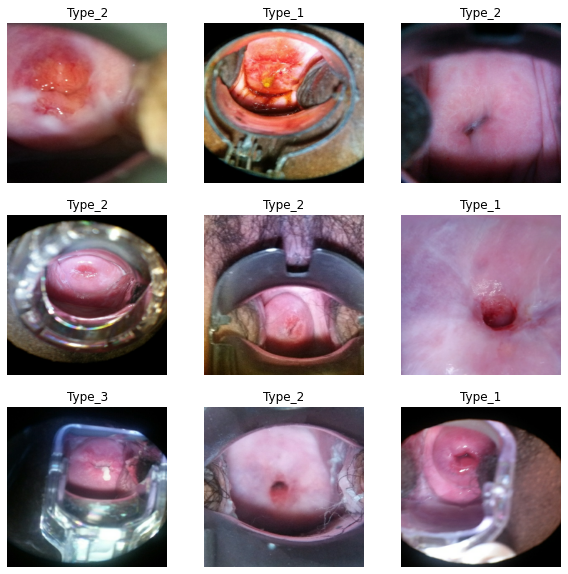

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
normalization_layer = layers.Rescaling(1./255)

In [16]:
# Переводит значения из [0, 255], в [0,1]
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [21]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [22]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
31/31 [==============================] - 3s 77ms/step - loss: 1.5100 - accuracy: 0.4267 - val_loss: 1.0422 - val_accuracy: 0.4608
Epoch 2/10
31/31 [==============================] - 2s 67ms/step - loss: 1.0581 - accuracy: 0.4603 - val_loss: 1.0289 - val_accuracy: 0.4798
Epoch 3/10
31/31 [==============================] - 2s 67ms/step - loss: 1.0327 - accuracy: 0.4847 - val_loss: 1.0266 - val_accuracy: 0.4798
Epoch 4/10
31/31 [==============================] - 2s 68ms/step - loss: 1.0340 - accuracy: 0.4766 - val_loss: 1.0198 - val_accuracy: 0.4846
Epoch 5/10
31/31 [==============================] - 2s 67ms/step - loss: 1.0272 - accuracy: 0.4888 - val_loss: 1.0197 - val_accuracy: 0.4822
Epoch 6/10
31/31 [==============================] - 2s 69ms/step - loss: 1.0162 - accuracy: 0.4715 - val_loss: 1.0301 - val_accuracy: 0.4703
Epoch 7/10
31/31 [==============================] - 3s 90ms/step - loss: 1.0116 - accuracy: 0.4817 - val_loss: 0.9919 - val_accuracy: 0.4798
Epoch 8/10
31

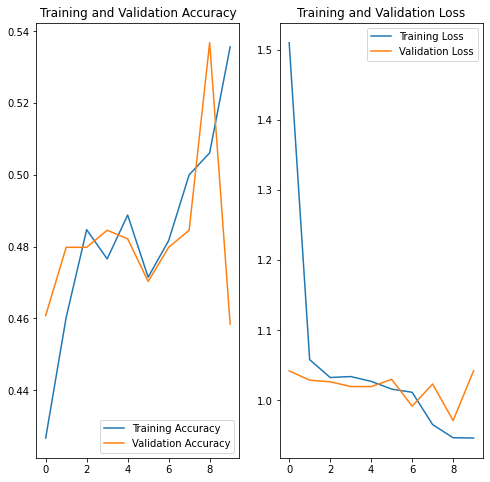

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [45]:
test_image_data_result = pd.DataFrame(columns=["image_name", *class_names])

for image_name in os.listdir(test_dir):
    test_image = tf.keras.utils.load_img(
                        test_dir + image_name, target_size=(img_height, img_width)
                        )
    
    img_array = tf.keras.utils.img_to_array(test_image)
    img_array = tf.expand_dims(img_array, 0)

    test_output = model.predict(img_array)
    
    test_output = tf.nn.softmax(test_output)

    test_output = test_output.numpy().tolist()[0]

    
    temp_dict = dict(zip(class_names, test_output))
    temp_dict["image_name"] = image_name
            
    test_image_data_result.loc[len(test_image_data_result)] = temp_dict

1/1 [==============================] - 0s 23ms/step


In [48]:
test_image_data_result.to_csv("submission_tf1.csv", index=False)
# Submission на public score составил 0.938, private - 1.12 
# (в сравнении с torch 0.985 publiс и 0.968 на private)
# стоит отметить, что конфигурации сетей были разные.